# Word Sense Disambiguation и Word Sense Induction

In [1]:
from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.chdir('gdrive/My Drive/Colab Notebooks/nlp_data')

In [ ]:
!pip install pymorphy2
!pip install pymystem3==0.1.10
!pip install rusenttokenize
!pip install razdel

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from lxml import html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from pymorphy2 import MorphAnalyzer
from string import punctuation
import json, os, re, sys
from collections import Counter
import numpy as np
from razdel import tokenize as razdel_tokenize
from matplotlib import pyplot as plt
import gensim
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import tqdm
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    words = [token.text.strip(punct) for token in list(razdel_tokenize(text))]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return words


## WordNet

In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Группа синонимичных слов в WordNet'е называются синсеты. 

In [6]:
# всего синсетов
len(list(wn.all_synsets()))

117659

Синсеты для слова можно достать вот так:

In [7]:
wn.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

Можно ограничить часть речи:

In [8]:
wn.synsets('go', pos='v')[:5]

[Synset('travel.v.01'),
 Synset('go.v.02'),
 Synset('go.v.03'),
 Synset('become.v.01'),
 Synset('go.v.05')]

У многих из них есть определения:

In [9]:
word = 'day'
for synset in wn.synsets(word)[:5]:
    print(word + ' - ' + synset.definition())

day - time for Earth to make a complete rotation on its axis
day - some point or period in time
day - a day assigned to a particular purpose or observance
day - the time after sunrise and before sunset while it is light outside
day - the recurring hours when you are not sleeping (especially those when you are working)


И даже примеры:

In [10]:
word = 'day'
for synset in wn.synsets(word)[:5]:
    print(word + ' - ' + ' | '.join(synset.examples()))

day - two days later they left | they put on two performances every day | there are 30,000 passengers per day
day - it should arrive any day now | after that day she never trusted him again | those were the days | these days it is not unusual
day - Mother's Day
day - the dawn turned night into day | it is easier to make the repairs in the daytime
day - my day began early this morning | it was a busy day on the stock exchange | she called it a day and went to bed


Посмотрим на связанные синсеты (гипонимы, антонимы, синонимы, меронимы).

In [11]:
s = wn.synsets('car')[0]

In [12]:
s.part_meronyms()[:5]

[Synset('accelerator.n.01'),
 Synset('air_bag.n.01'),
 Synset('auto_accessory.n.01'),
 Synset('automobile_engine.n.01'),
 Synset('automobile_horn.n.01')]

Антонимы только достаются не очень удобно:

In [13]:
wn.synsets('good')[2].lemmas()[0].antonyms()

[Lemma('bad.n.01.bad')]

Можно засунуть это все в граф и нарисовать:

In [14]:
!pip install networkx

In [15]:
import networkx as nx

words = wn.synsets('car')
hyponyms = words[0].part_meronyms()
print(hyponyms)

G=nx.Graph()

for w in hyponyms: 
    G.add_edge(words[0].name().split('.')[0],
               w.name().split('.')[0], 
               weight=words[0].wup_similarity(w))

[Synset('accelerator.n.01'), Synset('air_bag.n.01'), Synset('auto_accessory.n.01'), Synset('automobile_engine.n.01'), Synset('automobile_horn.n.01'), Synset('buffer.n.06'), Synset('bumper.n.02'), Synset('car_door.n.01'), Synset('car_mirror.n.01'), Synset('car_seat.n.01'), Synset('car_window.n.01'), Synset('fender.n.01'), Synset('first_gear.n.01'), Synset('floorboard.n.02'), Synset('gasoline_engine.n.01'), Synset('glove_compartment.n.01'), Synset('grille.n.02'), Synset('high_gear.n.01'), Synset('hood.n.09'), Synset('luggage_compartment.n.01'), Synset('rear_window.n.01'), Synset('reverse.n.02'), Synset('roof.n.02'), Synset('running_board.n.01'), Synset('stabilizer_bar.n.01'), Synset('sunroof.n.01'), Synset('tail_fin.n.02'), Synset('third_gear.n.01'), Synset('window.n.02')]


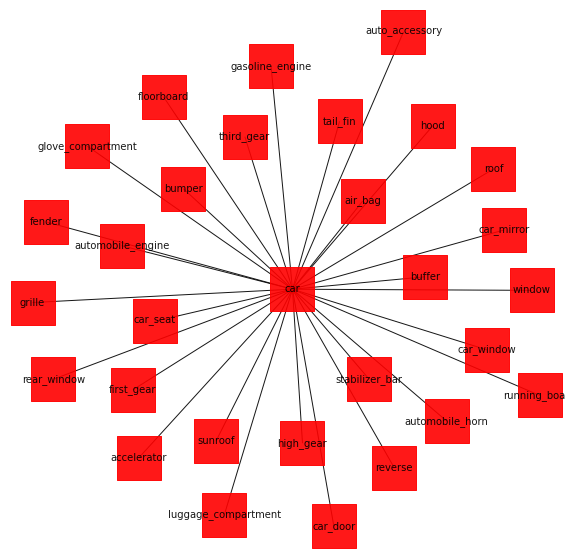

In [16]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx(G,with_labels=True,node_size=2000,
                 font_size=10,
                 node_shape='s',
                 alpha=0.9,
                 node_color='red')

Можно посчитать близость между синсетами (зависит от того, какой путь нужно пройти по этим связям от одного объекта до другого и есть ли он вообще)

In [17]:
car = wn.synsets('car')[0]
bike = wn.synsets('bike')[0]

In [18]:
bike.path_similarity(car)

0.3333333333333333

Есть и другие метрики:

In [19]:
wn.lch_similarity(bike, car)

2.538973871058276

In [20]:
wn.wup_similarity(bike, car)

0.9166666666666666

### Домашнее задание. Реализовать алгоритм Леска и проверить его на реальном датасете

Ворднет можно использовать для дизамбигуации. Самый простой алгоритм дизамбигуации - алгоритм Леска. В нём нужное значение слова находится через пересечение слов контекста, в котором употреблено это слово, с определениями значений слова из ворднета. Значение с максимальным пересечением - нужное.

In [33]:
def lesk(word, sentence):
  bestsense = 0
  maxoverlap = 0
  synsets = wn.synsets(word)

  for i, syns in enumerate(synsets):
    defi = syns.definition()
    def_words = normalize(defi)
    overlap = get_overlap(def_words, sentence)
        
    if overlap >= maxoverlap:
      maxoverlap = overlap
      bestsense = i
        
  return bestsense

def get_overlap(a, b):
  return len(list(set(a) & set(b)))

In [34]:
lesk('day', normalize('some point or period in time'))

1

In [35]:
# с помощью этого индекса достаем нужный синсет
wn.synsets('day')[1].definition()

'some point or period in time'

**Проверьте насколько хорошо работает такой метод на реальном датасете.** http://lcl.uniroma1.it/wsdeval/ - большой фреймворк для оценки WSD. Там много данных и я взял кусочек, чтобы не было проблем с памятью

In [36]:
corpus_wsd = []
corpus = open('corpus_wsd_50k.txt').read().split('\n\n')
for sent in corpus:
    corpus_wsd.append([s.split('\t') for s in sent.split('\n')])

Корпус состоит из предложений, где у каждого слова три поля - значение, лемма и само слово. Значение пустое, когда слово однозначное, а у многозначных слов стоит тэг вида **'long%3:00:02::'** Это тэг wordnet'ного формата

In [39]:
corpus_wsd[0]

[['', 'how', 'How'],
 ['long%3:00:02::', 'long', 'long'],
 ['', 'have', 'has'],
 ['', 'it', 'it'],
 ['be%2:42:03::', 'be', 'been'],
 ['', 'since', 'since'],
 ['', 'you', 'you'],
 ['review%2:31:00::', 'review', 'reviewed'],
 ['', 'the', 'the'],
 ['objective%1:09:00::', 'objective', 'objectives'],
 ['', 'of', 'of'],
 ['', 'you', 'your'],
 ['benefit%1:21:00::', 'benefit', 'benefit'],
 ['', 'and', 'and'],
 ['service%1:04:07::', 'service', 'service'],
 ['program%1:09:01::', 'program', 'program'],
 ['', '?', '?']]

Вот так можно достать соответствующий этому тэгу синсет:

In [40]:
wn.lemma_from_key('long%3:00:02::').synset()

Synset('long.a.01')

Когда с помощью алгоритма Леска вы найдете подходящее значение, их можно просто сравнить

In [41]:
wn.synsets('long')

[Synset('hanker.v.01'),
 Synset('long.a.01'),
 Synset('long.a.02'),
 Synset('long.s.03'),
 Synset('retentive.a.01'),
 Synset('long.a.05'),
 Synset('long.a.06'),
 Synset('long.s.07'),
 Synset('farseeing.s.02'),
 Synset('long.s.09'),
 Synset('long.r.01'),
 Synset('long.r.02')]

In [42]:
# тут подходит второй синсет (!в вашем решении вместо индекса единицы будет результат работы функции lesk)
wn.synsets('long')[1] == wn.lemma_from_key('long%3:00:02::').synset()

True

In [43]:
# можно сравнить со всеми, чтобы убедиться
[(syns, wn.synsets('long')[i] == wn.lemma_from_key('long%3:00:02::').synset()) 
  for i, syns in enumerate(wn.synsets('long'))]

[(Synset('hanker.v.01'), False),
 (Synset('long.a.01'), True),
 (Synset('long.a.02'), False),
 (Synset('long.s.03'), False),
 (Synset('retentive.a.01'), False),
 (Synset('long.a.05'), False),
 (Synset('long.a.06'), False),
 (Synset('long.s.07'), False),
 (Synset('farseeing.s.02'), False),
 (Synset('long.s.09'), False),
 (Synset('long.r.01'), False),
 (Synset('long.r.02'), False)]

**Вам нужно для каждого многозначного слова (т.е. у него есть тэг в первом поле) с помощью алгоритма Леска предсказать нужный синсет и сравнить с правильным. Посчитайте процент правильных предсказаний (accuracy).**

Если считается слишком долго, возьмите поменьше предложений (например, только тысячу)

In [76]:
true = 0
total = 0

for sent in corpus_wsd[:1000]:
  for s in sent:
    if s[0] != '':
      total += 1
      context = [i[1] for i in sent if i != s[2]]
      sense_id = lesk(s[1], context)
      if wn.synsets(s[1])[sense_id] == wn.lemma_from_key(s[0]).synset():
        true += 1

print(f'Accuracy: {true/total}')

Accuracy: 0.2588791512915129


### Дополнительный балл

Если хотите заработать дополнительный балл, попробуйте улучшить алгоритм Леска любым способом (например, использовать расстояние редактирования вместо пересечения или даже вставить машинное обучение)

In [47]:
pip install python-Levenshtein

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149801 sha256=e12753f46ef52f9fa9ba508c9545e4d7013901f17f9d4699c10a55e9d81a0225
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [49]:
import Levenshtein

In [53]:
def lev(word, sentence):
  bestsense = 0
  min_score = 1000000
  synsets = wn.synsets(word)

  for i, syns in enumerate(synsets):
    defi = syns.definition()
    def_words = normalize(defi)
    lev_score = get_lev(def_words, sentence)
        
    if lev_score <= min_score:
      min_score = lev_score
      bestsense = i
        
  return bestsense

def get_lev(a, b):
  return Levenshtein.distance(' '.join(a),' '.join(b))

In [54]:
lev('day', normalize('some point or period in time'))

1

In [55]:
wn.synsets('day')[1].definition()

'some point or period in time'

In [77]:
true = 0
total = 0

for sent in corpus_wsd[:1000]:
  for s in sent:
    if s[0] != '':
      total += 1
      context = [i[1] for i in sent if i != s[2]]
      sense_id = lev(s[1], context)
      if wn.synsets(s[1])[sense_id] == wn.lemma_from_key(s[0]).synset():
        true += 1

print(f'Accuracy: {true/total}')

Accuracy: 0.31526752767527677


Результаты получились получше, чем у Леска

На всякий случай привожу второй (расписанный) вариант подсчета расстояния

In [71]:
def levenshteinDistance(a, b):
    if len(a) > len(b):
        a, b = b, a

    dists = range(len(a) + 1)
    for id_2, c_2 in enumerate(b):
        all_dist = [id_2+1]
        for id_1, c_1 in enumerate(a):
            if c_1 == c_2:
                all_dist.append(dists[id_1])
            else:
                all_dist.append(1 + min((dists[id_1], dists[id_1 + 1], all_dist[-1])))
        dists = all_dist
        
    return dists[-1]

In [72]:
def lev_2(word, sentence):
  bestsense = 0
  min_score = 1000000
  synsets = wn.synsets(word)

  for i, syns in enumerate(synsets):
    defi = syns.definition()
    def_words = normalize(defi)
    lev_score = levenshteinDistance(' '.join(def_words), ' '.join(sentence))
        
    if lev_score <= min_score:
      min_score = lev_score
      bestsense = i
        
  return bestsense

In [73]:
lev_2('day', normalize('some point or period in time'))

1

In [74]:
wn.synsets('day')[1].definition()

'some point or period in time'

In [78]:
true = 0
total = 0

for sent in corpus_wsd[:1000]:
  for s in sent:
    if s[0] != '':
      total += 1
      context = [i[1] for i in sent if i != s[2]]
      sense_id = lev_2(s[1], context)
      if wn.synsets(s[1])[sense_id] == wn.lemma_from_key(s[0]).synset():
        true += 1

print(f'Accuracy: {true/total}')

Accuracy: 0.31526752767527677


Результат получился тем же самым